In [1]:
import cython
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from CyRK import nb2cy, cyrk_ode, nbrk_ode

In [2]:
RTOL = 1.0e-7
ATOL = 1.0e-8

pendulum_y0 = np.asarray((0.01, 0.), dtype=np.float64)
pendulum_args = (1., 1., 9.81)  # length [m], mass [kg], acceleration due to gravity [m s-2]
pendulum_time_span_1 = (0., 10.)
pendulum_time_span_2 = (0., 100.)

pendulum_time_span_10 = (0., 10000.)

@njit(cache=True)
def pendulum_nb(t, y, l, m, g):

    # External torque
    torque = 0.1 * np.sin(t)

    y0 = y[0]  # Angular deflection [rad]
    y1 = y[1]  # Angular velocity [rad s-1]
    dy = np.empty_like(y)
    dy[0] = y1
    dy[1] = (-3. * g / (2. * l)) * np.sin(y0) + (3. / (m * l**2)) * torque
    return dy


pendulum_cy = nb2cy(pendulum_nb, use_njit=True, cache_njit=True)

In [3]:
print('Working on Cython (function) integration...')
t_cy, y_cy, _, _ = cyrk_ode(pendulum_cy, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
print(t_cy.size)
print('Done.')
print('Working on Numba integration...')
t_nb, y_nb, _, _ = nbrk_ode(pendulum_nb, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
print('Done.')

Working on Cython (function) integration...
182
Done.
Working on Numba integration...
Done.


In [4]:
print('Performance')
print('Cython (function)')
# v0.5.3: 1.19ms, 1.2ms, 1.2ms
# v0.6.2: 1.02ms, 1.02ms

%timeit cyrk_ode(pendulum_cy, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

print('\nNumba')
# v0.5.3: 199us, 201us, 200us
# v0.6.2: 187us, 188us

%timeit nbrk_ode(pendulum_nb, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

Performance
Cython (function)
1.29 ms ± 80 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Numba
302 µs ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


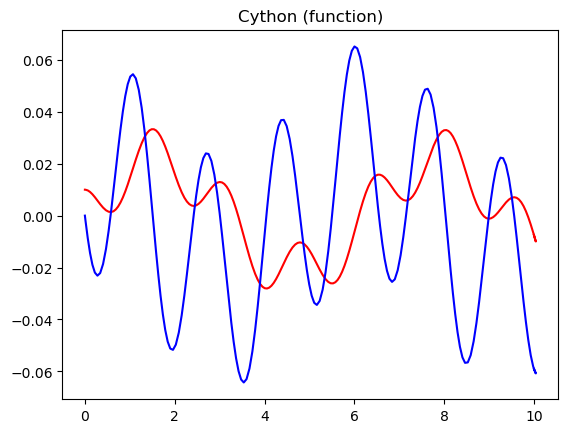

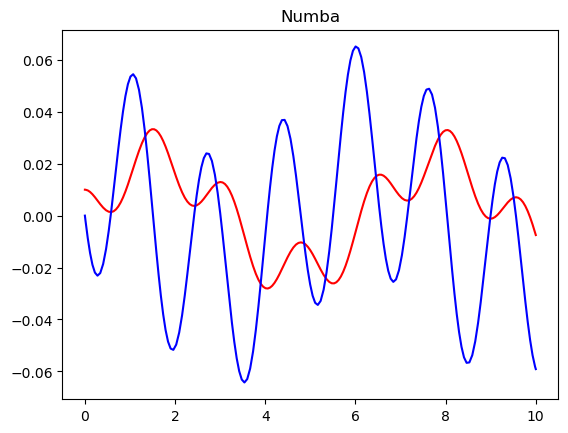

In [5]:
fig_cy, ax_cy = plt.subplots()
ax_cy.plot(t_cy, y_cy[0], 'r')
ax_cy.plot(t_cy, y_cy[1], 'b')
ax_cy.set(title='Cython (function)')
fig_nb, ax_nb = plt.subplots()
ax_nb.plot(t_nb, y_nb[0], 'r')
ax_nb.plot(t_nb, y_nb[1], 'b')
ax_nb.set(title='Numba')
plt.show()

In [6]:
%load_ext Cython

In [11]:
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

In [21]:
%%cython --annotate --force
# distutils: language = c++
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

import cython
import sys
import numpy as np
cimport numpy as np
np.import_array()

from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin

from CyRK.array.interp cimport interp_array, interp_complex_array
from CyRK.rk.rk cimport (
    RK23_C, RK23_B, RK23_E, RK23_A, RK23_order, RK23_error_order, RK23_n_stages, RK23_LEN_C, RK23_LEN_B, RK23_LEN_E,
    RK23_LEN_E3, RK23_LEN_E5, RK23_LEN_A0, RK23_LEN_A1,
    RK45_C, RK45_B, RK45_E, RK45_A, RK45_order, RK45_error_order, RK45_n_stages, RK45_LEN_C, RK45_LEN_B, RK45_LEN_E,
    RK45_LEN_E3, RK45_LEN_E5, RK45_LEN_A0, RK45_LEN_A1,
    DOP_C_REDUCED, DOP_B, DOP_E3, DOP_E5, DOP_A_REDUCED, DOP_order, DOP_error_order, DOP_n_stages,
    DOP_n_stages_extended, DOP_LEN_C, DOP_LEN_B, DOP_LEN_E, DOP_LEN_E3, DOP_LEN_E5, DOP_LEN_A0, DOP_LEN_A1)

# # Integration Constants
# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9
cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf
cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.
cdef Py_ssize_t MAX_INT_SIZE = int(0.95 * sys.maxsize)

cdef double cabs(double complex value) noexcept nogil:
    """ Absolute value function for complex-valued inputs.
    
    Parameters
    ----------
    value : float (double complex)
        Complex-valued number.
         
    Returns
    -------
    value_abs : float (double)
        Absolute value of `value`.
    """

    cdef double v_real
    cdef double v_imag
    v_real = value.real
    v_imag = value.imag

    return sqrt(v_real * v_real + v_imag * v_imag)

# Define fused type to handle both float and complex-valued versions of y and dydt.
ctypedef fused double_numeric:
    double
    double complex
    

cdef double dabs(double_numeric value) noexcept nogil:
    """ Absolute value function for either float or complex-valued inputs.
    
    Checks the type of value and either utilizes `cabs` (for double complex) or `fabs` (for floats).
    
    Parameters
    ----------
    value : float (double_numeric)
        Float or complex-valued number.

    Returns
    -------
    value_abs : float (double)
        Absolute value of `value`.
    """
    cdef double result
    
    # Check the type of value
    if double_numeric is cython.doublecomplex:
        result = cabs(value)
    else:
        result = fabs(value)
    return result

def cyrk_ode_2(
    diffeq,
    (double, double) t_span,
    const double_numeric[:] y0,
    tuple args = None,
    double rtol = 1.e-6,
    double atol = 1.e-8,
    double max_step_size = MAX_STEP,
    double first_step = 0.,
    unsigned char rk_method = 1,
    double[:] t_eval = None,
    bool_cpp_t capture_extra = False,
    Py_ssize_t num_extra = 0,
    bool_cpp_t interpolate_extra = False,
    unsigned int expected_size = 0,
    unsigned int max_steps = 0
    ):
    """ A Numba-safe Runge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step_size : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            2 = DOP853
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.
    capture_extra : bool = False
        If True, then additional output from the differential equation will be collected (but not used to determine
         integration error).
         Example:
            ```
            def diffeq(t, y, dy):
                a = ... some function of y and t.
                dy[0] = a**2 * sin(t) - y[1]
                dy[1] = a**3 * cos(t) + y[0]

                # Storing extra output in dy even though it is not part of the diffeq.
                dy[2] = a
            ```
    num_extra : int = 0
        The number of extra outputs the integrator should expect. With the previous example there is 1 extra output.
    interpolate_extra : bool = False
        If True, and if `t_eval` was provided, then the integrator will interpolate the extra output values at each
         step in `t_eval`.
    expected_size : int = 0
        The integrator must pre-allocate memory to store results from the integration. It will attempt to use arrays sized to `expected_size`. However, if this is too small or too large then performance will be impacted. It is recommended you try out different values based on the problem you are trying to solve.
        If `expected_size=0` (the default) then the solver will attempt to guess a best size. Currently this is a very basic guess so it is not recommended.
        It is better to overshoot than undershoot this guess.
    max_steps : int = 0
        Maximum number of steps integrator is allowed to take.
        If set to 0 (the default) then an infinite number of steps are allowed.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """
    # Setup loop variables
    cdef Py_ssize_t s, i, j

    # Setup integration variables
    cdef char status, old_status
    cdef str message

    # Determine information about the differential equation based on its initial conditions
    cdef Py_ssize_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef bool_cpp_t y_is_complex
    y_size = y0.size
    y_is_complex = False
    y_size_dbl = <double>y_size
    y_size_sqrt = sqrt(y_size_dbl)

    # Check the type of the values in y0
    if double_numeric is cython.double:
        DTYPE = np.float64
    elif double_numeric is cython.doublecomplex:
        DTYPE = np.complex128
        y_is_complex = True
    else:
        # Cyrk only supports float64 and complex128.
        status = -8
        message = "Attribute error."
        raise Exception('Unexpected type found for initial conditions (y0).')

    # Build time domain
    cdef double t_start, t_end, t_delta, t_delta_check, t_delta_abs, direction_inf, t_old, t_new, time_
    cdef bool_cpp_t direction_flag
    t_start = t_span[0]
    t_end   = t_span[1]
    t_delta = t_end - t_start
    t_delta_abs = fabs(t_delta)
    t_delta_check = t_delta_abs
    if t_delta >= 0.:
        # Integration is moving forward in time.
        direction_flag = True
        direction_inf = INF
    else:
        # Integration is moving backwards in time.
        direction_flag = False
        direction_inf = -INF

    # Pull out information on t-eval
    cdef Py_ssize_t len_teval
    if t_eval is None:
        len_teval = 0
    else:
        len_teval = t_eval.size

    # Pull out information on args
    cdef bool_cpp_t use_args
    if args is None:
        use_args = False
    else:
        use_args = True

    # Set integration flags
    cdef bool_cpp_t success, step_accepted, step_rejected, step_error, run_interpolation, \
        store_extras_during_integration
    success           = False
    step_accepted     = False
    step_rejected     = False
    step_error        = False
    run_interpolation = False
    store_extras_during_integration = capture_extra
    if len_teval > 0:
        run_interpolation = True
    if run_interpolation and not interpolate_extra:
        # If y is eventually interpolated but the extra outputs are not being interpolated, then there is
        #  no point in storing the values during the integration. Turn off this functionality to save
        #  on computation.
        store_extras_during_integration = False

    # # Determine integration parameters
    # Check tolerances
    if rtol < EPS_100:
        rtol = EPS_100

    #     atol_arr = np.asarray(atol, dtype=np.complex128)
    #     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
    #         # atol must be either the same for all y or must be provided as an array, one for each y.
    #         raise Exception

    # Determine maximum number of steps
    cdef Py_ssize_t max_steps_touse
    cdef bool_cpp_t use_max_steps
    if max_steps == 0:
        use_max_steps = False
        max_steps_touse = 0
    elif max_steps < 0:
        raise AttributeError('Negative number of max steps provided.')
    else:
        use_max_steps = True
        max_steps_touse = min(max_steps, MAX_INT_SIZE)

    # Expected size of output arrays.
    cdef double temp_expected_size
    cdef Py_ssize_t expected_size_to_use, num_concats
    if expected_size == 0:
        # CySolver will attempt to guess on a best size for the arrays.
        temp_expected_size = 100. * t_delta_abs * fmax(1., (1.e-6 / rtol))
        temp_expected_size = fmax(temp_expected_size, 100.)
        temp_expected_size = fmin(temp_expected_size, 10_000_000.)
        expected_size_to_use = <Py_ssize_t>temp_expected_size
    else:
        expected_size_to_use = <Py_ssize_t>expected_size
    # This variable tracks how many times the storage arrays have been appended.
    # It starts at 1 since there is at least one storage array present.
    num_concats = 1

    # Initialize arrays that are based on y's size and type.
    y_new    = np.empty(y_size, dtype=DTYPE, order='C')
    y_old    = np.empty(y_size, dtype=DTYPE, order='C')
    dydt_new = np.empty(y_size, dtype=DTYPE, order='C')
    dydt_old = np.empty(y_size, dtype=DTYPE, order='C')

    # Setup memory views for these arrays
    cdef double_numeric[:] y_new_view, y_old_view, dydt_new_view, dydt_old_view
    y_new_view    = y_new
    y_old_view    = y_old
    dydt_new_view = dydt_new
    dydt_old_view = dydt_old

    # Store y0 into the y arrays
    cdef double_numeric y_value
    for i in range(y_size):
        y_value = y0[i]
        y_new_view[i] = y_value
        y_old_view[i] = y_value

    # If extra output is true then the output of the diffeq will be larger than the size of y0.
    # Determine that extra size by calling the diffeq and checking its size.
    cdef Py_ssize_t extra_start, total_size, store_loop_size
    extra_start = y_size
    total_size  = y_size + num_extra
    # Create arrays based on this total size
    diffeq_out     = np.empty(total_size, dtype=DTYPE, order='C')
    y0_plus_extra  = np.empty(total_size, dtype=DTYPE, order='C')
    extra_result   = np.empty(num_extra, dtype=DTYPE, order='C')

    # Setup memory views
    cdef double_numeric[:] diffeq_out_view, y0_plus_extra_view, extra_result_view
    diffeq_out_view     = diffeq_out
    y0_plus_extra_view  = y0_plus_extra
    extra_result_view   = extra_result

    # Capture the extra output for the initial condition.
    if capture_extra:
        if use_args:
            diffeq(t_start, y_new, diffeq_out, *args)
        else:
            diffeq(t_start, y_new, diffeq_out)

        # Extract the extra output from the function output.
        for i in range(total_size):
            if i < extra_start:
                # Pull from y0
                y0_plus_extra_view[i] = y0[i]
            else:
                # Pull from extra output
                y0_plus_extra_view[i] = diffeq_out_view[i]
        if store_extras_during_integration:
            store_loop_size = total_size
        else:
            store_loop_size = y_size
    else:
        # No extra output
        store_loop_size = y_size

    y0_to_store = np.empty(store_loop_size, dtype=DTYPE, order='C')
    cdef double_numeric[:] y0_to_store_view
    y0_to_store_view = y0_to_store
    for i in range(store_loop_size):
        if store_extras_during_integration:
            y0_to_store_view[i] = y0_plus_extra_view[i]
        else:
            y0_to_store_view[i] = y0[i]

    # # Determine RK scheme
    cdef unsigned char rk_order, error_order
    cdef Py_ssize_t rk_n_stages, rk_n_stages_plus1, rk_n_stages_extended
    cdef Py_ssize_t len_C, len_B, len_E, len_E3, len_E5, len_A0, len_A1
    cdef double error_pow, error_expo, error_norm5, error_norm3, error_norm, error_norm_abs, error_norm3_abs, error_norm5_abs, error_denom

    if rk_method == 0:
        # RK23 Method
        rk_order    = RK23_order
        error_order = RK23_error_order
        rk_n_stages = RK23_n_stages
        len_C       = RK23_LEN_C
        len_B       = RK23_LEN_B
        len_E       = RK23_LEN_E
        len_E3      = RK23_LEN_E3
        len_E5      = RK23_LEN_E5
        len_A0      = RK23_LEN_A0
        len_A1      = RK23_LEN_A1
    elif rk_method == 1:
        # RK45 Method
        rk_order    = RK45_order
        error_order = RK45_error_order
        rk_n_stages = RK45_n_stages
        len_C       = RK45_LEN_C
        len_B       = RK45_LEN_B
        len_E       = RK45_LEN_E
        len_E3      = RK45_LEN_E3
        len_E5      = RK45_LEN_E5
        len_A0      = RK45_LEN_A0
        len_A1      = RK45_LEN_A1
    elif rk_method == 2:
        # DOP853 Method
        rk_order    = DOP_order
        error_order = DOP_error_order
        rk_n_stages = DOP_n_stages
        len_C       = DOP_LEN_C
        len_B       = DOP_LEN_B
        len_E       = DOP_LEN_E
        len_E3      = DOP_LEN_E3
        len_E5      = DOP_LEN_E5
        len_A0      = DOP_LEN_A0
        len_A1      = DOP_LEN_A1

        rk_n_stages_extended = DOP_n_stages_extended
    else:
        status = -8
        message = "Attribute error."
        raise AttributeError(
            'Unexpected rk_method provided. Currently supported versions are:\n'
            '\t0 = RK23\n'
            '\t1 = RK34\n'
            '\t2 = DOP853')

    rk_n_stages_plus1 = rk_n_stages + 1
    error_expo = 1. / (<double>error_order + 1.)

    # Build RK Arrays. Note that all are 1D except for A and K.
    A      = np.empty((len_A0, len_A1), dtype=DTYPE, order='C')
    B      = np.empty(len_B, dtype=DTYPE, order='C')
    C      = np.empty(len_C, dtype=np.float64, order='C')  # C is always float no matter what y0 is.
    E      = np.empty(len_E, dtype=DTYPE, order='C')
    E3     = np.empty(len_E3, dtype=DTYPE, order='C')
    E5     = np.empty(len_E5, dtype=DTYPE, order='C')
    K      = np.zeros((rk_n_stages_plus1, y_size), dtype=DTYPE, order='C')  # It is important K be initialized with 0s

    # Setup memory views.
    cdef double_numeric[:] B_view, E_view, E3_view, E5_view
    cdef double_numeric[:, :] A_view, K_view
    cdef double_numeric A_at_sj, B_at_j, error_dot_1, error_dot_2
    cdef double[:] C_view
    A_view      = A
    B_view      = B
    C_view      = C
    E_view      = E
    E3_view     = E3
    E5_view     = E5
    K_view      = K

    # Populate values based on externally defined constants.
    if rk_method == 0:
        # RK23 Method
        for i in range(len_A0):
            for j in range(len_A1):
                A_view[i, j] = RK23_A[i][j]
        for i in range(len_B):
            B_view[i] = RK23_B[i]
        for i in range(len_C):
            C_view[i] = RK23_C[i]
        for i in range(len_E):
            E_view[i] = RK23_E[i]
            # Dummy Variables, set equal to E
            E3_view[i] = RK23_E[i]
            E5_view[i] = RK23_E[i]
    elif rk_method == 1:
        # RK45 Method
        for i in range(len_A0):
            for j in range(len_A1):
                A_view[i, j] = RK45_A[i][j]
        for i in range(len_B):
            B_view[i] = RK45_B[i]
        for i in range(len_C):
            C_view[i] = RK45_C[i]
        for i in range(len_E):
            E_view[i] = RK45_E[i]
            # Dummy Variables, set equal to E
            E3_view[i] = RK45_E[i]
            E5_view[i] = RK45_E[i]
    else:
        # DOP853 Method
        for i in range(len_A0):
            for j in range(len_A1):
                A_view[i, j] = DOP_A_REDUCED[i][j]
        for i in range(len_B):
            B_view[i] = DOP_B[i]
        for i in range(len_C):
            C_view[i] = DOP_C_REDUCED[i]
        for i in range(len_E):
            E3_view[i] = DOP_E3[i]
            E5_view[i] = DOP_E5[i]
            E_view[i] = DOP_E5[i]
            # Dummy Variables, set equal to E3
            E_view[i] = DOP_E3[i]

    # Initialize variables for start of integration
    if not capture_extra:
        # If `capture_extra` is True then this step was already performed.
        if use_args:
            diffeq(t_start, y_new, diffeq_out, *args)
        else:
            diffeq(t_start, y_new, diffeq_out)

    t_old = t_start
    t_new = t_start
    # Initialize dydt arrays.
    for i in range(y_size):
        dydt_new_view[i] = diffeq_out_view[i]
        dydt_old_view[i] = dydt_new_view[i]
    
    # Setup storage arrays
    # These arrays are built to fit a number of points equal to `expected_size_to_use`
    # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
    cdef double_numeric[:, :] y_results_array_view, y_results_array_new_view, solution_y_view
    cdef double[:] time_domain_array_view, time_domain_array_new_view, solution_t_view
    y_results_array        = np.empty((store_loop_size, expected_size_to_use), dtype=DTYPE, order='C')
    time_domain_array      = np.empty(expected_size_to_use, dtype=np.float64, order='C')
    y_results_array_view   = y_results_array
    time_domain_array_view = time_domain_array

    cdef np.ndarray[np.float64_t, ndim=1, mode='c'] scale_arr
    cdef double[:] scale_view
    cdef double scale
    scale_arr = np.empty(y_size, dtype=np.float64, order='C')
    scale_view = scale_arr


    # Load initial conditions into output arrays
    time_domain_array_view[0] = t_start
    for i in range(store_loop_size):
        if store_extras_during_integration:
            y_results_array_view[i] = y0_plus_extra_view[i]
        else:
            y_results_array_view[i] = y0[i]

    # # Determine size of first step.
    cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1
    cdef double ZP
    cdef double_numeric ZA
    
    if first_step == 0.:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):
                ZA = y_old_view[i]
                ZP = dabs(ZA)
                scale = atol + ZP * rtol

                d0_abs = dabs(y_old_view[i] / scale)
                d1_abs = dabs(dydt_old_view[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / y_size_sqrt
            d1 = sqrt(d1) / y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0
            t_new = t_old + h0_direction
            for i in range(y_size):
                y_new_view[i] = y_old_view[i] + h0_direction * dydt_old_view[i]

            if use_args:
                diffeq(t_new, y_new, diffeq_out, *args)
            else:
                diffeq(t_new, y_new, diffeq_out)

            # Find the norm for d2
            d2 = 0.
            for i in range(y_size):
                dydt_new_view[i] = diffeq_out_view[i]
                scale = atol + dabs(y_old_view[i]) * rtol
                d2_abs = dabs( (dydt_new_view[i] - dydt_old_view[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = max(10. * fabs(nextafter(t_old, direction_inf) - t_old), min(100. * h0, h1))
    else:
        if first_step <= 0.:
            status = -8
            message = "Attribute error."
            raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
        elif first_step > t_delta_abs:
            status = -8
            message = "Attribute error."
            raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
        step_size = first_step

    # # Main integration loop
    cdef double min_step, step_factor, step
    cdef double c
    cdef double_numeric K_scale
    cdef Py_ssize_t len_t
    status = 0
    message = "Integration is/was ongoing (perhaps it was interrupted?)."
    len_t  = 1  # There is an initial condition provided so the time length is already 1

    if y_size == 0:
        status = -6
        message = "Integration never started: y-size is zero."

    while status == 0:
        if t_new == t_end:
            t_old = t_end
            status = 1
            break

        if use_max_steps:
            if len_t > max_steps_touse:
                status = -2
                message = "Maximum number of steps (set by user) exceeded during integration."
                break
        else:
            if len_t > MAX_INT_SIZE:
                status = -3
                message = "Maximum number of steps (set by system architecture) exceeded during integration."
                break

        # Run RK integration step
        # Determine step size based on previous loop
        # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
        min_step = 10. * fabs(nextafter(t_old, direction_inf) - t_old)
        # Look for over/undershoots in previous step size
        if step_size > max_step_size:
            step_size = max_step_size
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error    = False

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                status     = -1
                break

            # Move time forward for this particular step size
            if direction_flag:
                step = step_size
                t_delta_check = t_new - t_end
            else:
                step = -step_size
                t_delta_check = t_end - t_new
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if t_delta_check > 0.:
                t_new = t_end

                # Correct the step if we were at the end of integration
                step = t_new - t_old
                if direction_flag:
                    step_size = step
                else:
                    step_size = -step

            # Calculate derivative using RK method
            for i in range(y_size):
                K_view[0, i] = dydt_old_view[i]

            for s in range(1, len_C):
                c = C_view[s]
                time_ = t_old + c * step

                # Dot Product (K, a) * step
                for j in range(s):
                    A_at_sj = A_view[s, j]
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_new_view[i] = y_old_view[i]

                        y_new_view[i] = y_new_view[i] + (K_view[j, i] * A_at_sj * step)

                if use_args:
                    diffeq(time_, y_new, diffeq_out, *args)
                else:
                    diffeq(time_, y_new, diffeq_out)

                for i in range(y_size):
                    K_view[s, i] = diffeq_out_view[i]

            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                B_at_j = B_view[j]
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new_view[i] = y_old_view[i]
                    y_new_view[i] = y_new_view[i] + (K_view[j, i] * B_at_j * step)

            if use_args:
                diffeq(t_new, y_new, diffeq_out, *args)
            else:
                diffeq(t_new, y_new, diffeq_out)


            for i in range(store_loop_size):
                if i < extra_start:
                    # Set diffeq results
                    dydt_new_view[i] = diffeq_out_view[i]

                    # Find scale of y for error calculations
                    scale_view[i] = atol + max(dabs(y_old_view[i]), dabs(y_new_view[i])) * rtol

                    # Set last array of K equal to dydt
                    K_view[rk_n_stages, i] = dydt_new_view[i]

                else:
                    # Set extra results
                    extra_result_view[i - extra_start] = diffeq_out_view[i]

            if rk_method == 2:
                # Calculate Error for DOP853
                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                for i in range(y_size):
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.
                            error_dot_2 = 0.

                        scale = scale_view[i]
                        K_scale = K_view[j, i] / <double_numeric>scale
                        error_dot_1 += K_scale * E3_view[j]
                        error_dot_2 += K_scale * E5_view[j]

                    error_norm3_abs = dabs(error_dot_1)
                    error_norm5_abs = dabs(error_dot_2)

                    error_norm3 += (error_norm3_abs * error_norm3_abs)
                    error_norm5 += (error_norm5_abs * error_norm5_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / sqrt(error_denom * y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                # Dot Product (K, E) * step / scale
                error_norm = 0.
                for i in range(y_size):
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.

                        scale = scale_view[i]
                        K_scale = K_view[j, i] / <double_numeric> scale
                        error_dot_1 += K_scale * E_view[j] * step

                    error_norm_abs = dabs(error_dot_1)
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    error_pow = error_norm**-error_expo
                    step_factor = min(MAX_FACTOR, SAFETY * error_pow)

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                error_pow = error_norm**-error_expo
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_pow)
                step_rejected = True

        if step_error:
            # Issue with step convergence
            status = -1
            message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
            break
        elif not step_accepted:
            # Issue with step convergence
            status = -7
            message = "Error in step size calculation:\n\tError in step size acceptance."
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        for i in range(y_size):
            y_old_view[i] = y_new_view[i]
            dydt_old_view[i] = dydt_new_view[i]

        # Save data
        if len_t >= (num_concats * expected_size_to_use):                
            # There is more data than we have room in our arrays. 
            # Build new arrays with more space.
            # OPT: Note this is an expensive operation. 
            num_concats += 1
            new_size = num_concats * expected_size_to_use
            time_domain_array_new      = np.empty(new_size, dtype=np.float64, order='C')
            y_results_array_new        = np.empty((store_loop_size, new_size), dtype=DTYPE, order='C')
            time_domain_array_new_view = time_domain_array_new
            y_results_array_new_view   = y_results_array_new
            
            # Loop through time to fill in these new arrays with the old values
            for i in range(len_t):
                time_domain_array_new_view[i] = time_domain_array_view[i]
                
                for j in range(store_loop_size):
                    y_results_array_new_view[j, i] = y_results_array_view[j, i]
            
            # No longer need the old arrays. Change where the view is pointing and delete them.
            y_results_array_view = y_results_array_new
            time_domain_array_view = time_domain_array_new
            # TODO: Delete the old arrays?
        
        # There should be room in the arrays to add new data.
        time_domain_array_view[len_t] = t_new
        # To match the format that scipy follows, we will take the transpose of y.
        for i in range(store_loop_size):
            if i < extra_start:
                # Pull from y result
                y_results_array_view[i, len_t] = y_new_view[i]
            else:
                # Pull from extra
                y_results_array_view[i, len_t] = extra_result_view[i - extra_start]

        # Increase number of time points.
        len_t += 1

    # # Clean up output.
    if status == 1:
        success = True
        message = "Integration completed without issue."

    # Create output arrays. To match the format that scipy follows, we will take the transpose of y.
    if success:
        # Build final output arrays.
        # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
        # This process will remove that junk and leave only the wanted data.
        solution_y = np.empty((store_loop_size, len_t), dtype=DTYPE, order='C')
        solution_t = np.empty(len_t, dtype=np.float64, order='C')

        # Link memory views
        solution_y_view = solution_y
        solution_t_view = solution_t

        # Populate values
        for i in range(len_t):
            solution_t_view[i] = time_domain_array_view[i]
            for j in range(store_loop_size):
                solution_y_view[j, i] = y_results_array_view[j, i]
    else:
        # Build nan arrays
        solution_y = np.nan * np.ones((store_loop_size, 1), dtype=DTYPE, order='C')
        solution_t = np.nan * np.ones(1, dtype=np.float64, order='C')

        # Link memory views
        solution_y_view = solution_y
        solution_t_view = solution_t

    cdef double_numeric[:, :] y_results_reduced_view
    cdef double_numeric[:] y_result_timeslice_view, y_result_temp_view

    if run_interpolation and success:
        old_status = status
        status = 2
        # User only wants data at specific points.

        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the integration loop for performance gains.
        y_results_reduced       = np.empty((total_size, len_teval), dtype=DTYPE, order='C')
        y_result_timeslice      = np.empty(len_t, dtype=DTYPE, order='C')
        y_result_temp           = np.empty(len_teval, dtype=DTYPE, order='C')
        y_results_reduced_view  = y_results_reduced
        y_result_timeslice_view = y_result_timeslice
        y_result_temp_view      = y_result_temp

        for j in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            # # Set timeslice equal to the time values at this y_j
            for i in range(len_t):
                y_result_timeslice_view[i] = solution_y_view[j, i]

            # Perform numerical interpolation
            if double_numeric is cython.doublecomplex:
                interp_complex_array(
                    t_eval,
                    solution_t_view,
                    y_result_timeslice_view,
                    y_result_temp_view
                    )
            else:
                interp_array(
                    t_eval,
                    solution_t_view,
                    y_result_timeslice_view,
                    y_result_temp_view
                    )

            # Store result.
            for i in range(len_teval):
                y_results_reduced_view[j, i] = y_result_temp_view[i]

        if capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice on what to output do we, like we do with y, interpolate all of those extras?
            #  or do we use the interpolation on y to find new values.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            if interpolate_extra:
                # Continue the interpolation for the extra values.
                for j in range(num_extra):
                    # np.interp only works on 1D arrays so we must loop through each of the variables:
                    # # Set timeslice equal to the time values at this y_j
                    for i in range(len_t):
                        y_result_timeslice_view[i] = solution_y_view[extra_start + j, i]

                    # Perform numerical interpolation
                    if double_numeric is cython.doublecomplex:
                        interp_complex_array(
                                t_eval,
                                solution_t_view,
                                y_result_timeslice_view,
                                y_result_temp_view
                                )
                    else:
                        interp_array(
                                t_eval,
                                solution_t_view,
                                y_result_timeslice_view,
                                y_result_temp_view
                                )

                    # Store result.
                    for i in range(len_teval):
                        y_results_reduced_view[extra_start + j, i] = y_result_temp_view[i]
            else:
                # Use y and t to recalculate the extra outputs
                y_interp = np.empty(y_size, dtype=DTYPE)
                y_interp_view = y_interp
                for i in range(len_teval):
                    time_ = t_eval[i]
                    for j in range(y_size):
                        y_interp_view[j] = y_results_reduced_view[j, i]

                    if use_args:
                        diffeq(time_, y_interp, diffeq_out, *args)
                    else:
                        diffeq(time_, y_interp, diffeq_out)

                    for j in range(num_extra):
                        y_results_reduced_view[extra_start + j, i] = diffeq_out_view[extra_start + j]

        # Replace the output y results and time domain with the new reduced one
        solution_y = np.empty((total_size, len_teval), dtype=DTYPE, order='C')
        solution_t = np.empty(len_teval, dtype=np.float64, order='C')
        solution_y_view = solution_y
        solution_t_view = solution_t

        # Update output arrays
        for i in range(len_teval):
            solution_t_view[i] = t_eval[i]
            for j in range(total_size):
                # To match the format that scipy follows, we will take the transpose of y.
                solution_y_view[j, i] = y_results_reduced_view[j, i]
        status = old_status

    return solution_t, solution_y, success, message



Content of stdout:
_cython_magic_34fcc3fc3c4604e1c4f0774f75195dad5d013a81.cpp
C:\Users\joepr\.ipython\cython\_cython_magic_34fcc3fc3c4604e1c4f0774f75195dad5d013a81.cpp(20611): warning C4244: '=': conversion from 'long' to 'char', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_34fcc3fc3c4604e1c4f0774f75195dad5d013a81.cpp(38815): warning C4244: '=': conversion from 'long' to 'unsigned char', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_34fcc3fc3c4604e1c4f0774f75195dad5d013a81.cpp(38855): warning C4244: '=': conversion from 'long' to 'unsigned char', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_34fcc3fc3c4604e1c4f0774f75195dad5d013a81.cpp(42609): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_34fcc3fc3c4604e1c4f0774f75195dad5d013a81.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_m

In [24]:
%%cython --annotate --force
# distutils: language = c++
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

import cython
import sys
import numpy as np
cimport numpy as np
np.import_array()
from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, isnan, NAN

from CyRK.array.interp cimport interp_array
from CyRK.rk.rk cimport (
    RK23_C, RK23_B, RK23_E, RK23_A, RK23_order, RK23_error_order, RK23_n_stages, RK23_LEN_C, RK23_LEN_B, RK23_LEN_E,
    RK23_LEN_E3, RK23_LEN_E5, RK23_LEN_A0, RK23_LEN_A1,
    RK45_C, RK45_B, RK45_E, RK45_A, RK45_order, RK45_error_order, RK45_n_stages, RK45_LEN_C, RK45_LEN_B, RK45_LEN_E,
    RK45_LEN_E3, RK45_LEN_E5, RK45_LEN_A0, RK45_LEN_A1,
    DOP_C_REDUCED, DOP_B, DOP_E3, DOP_E5, DOP_A_REDUCED, DOP_order, DOP_error_order, DOP_n_stages,
    DOP_n_stages_extended, DOP_LEN_C, DOP_LEN_B, DOP_LEN_E, DOP_LEN_E3, DOP_LEN_E5, DOP_LEN_A0, DOP_LEN_A1)

# # Integration Constants
# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9
cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf
cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.
cdef Py_ssize_t MAX_INT_SIZE = int(0.95 * sys.maxsize)

cdef (double, double) EMPTY_T_SPAN = (NAN, NAN)


cdef class CySolver:
    
    # Class attributes    
    # -- Live variables
    cdef double t_new, t_old
    cdef Py_ssize_t len_t
    cdef double[:] y_new_view, y_old_view, dy_new_view, dy_old_view
    cdef double[:] extra_output_view, extra_output_init_view
    
    # -- Dependent (y0) variable information
    cdef Py_ssize_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef const double[:] y0_view
    
    # -- RK method information
    cdef unsigned char rk_method
    cdef unsigned char rk_order, error_order, rk_n_stages, rk_n_stages_plus1, rk_n_stages_extended
    cdef double error_expo
    cdef Py_ssize_t len_C
    cdef double[:] B_view, E_view, E3_view, E5_view, C_view
    cdef double[:, :] A_view, K_view
    
    # -- Integration information
    cdef public char status
    cdef public str message
    cdef public bool_cpp_t success
    cdef double t_start, t_end, t_delta, t_delta_abs, direction_inf
    cdef bool_cpp_t direction_flag
    cdef double rtol, atol
    cdef double step_size, max_step_size
    cdef double first_step
    cdef Py_ssize_t expected_size, num_concats, max_steps
    cdef bool_cpp_t use_max_steps
    cdef double[:] scale_view
    cdef bool_cpp_t recalc_firststep
    
    # -- Optional args info
    cdef Py_ssize_t num_args
    cdef double[:] arg_array_view

    # -- Extra output info
    cdef bool_cpp_t capture_extra
    cdef Py_ssize_t num_extra

    # -- Interpolation info
    cdef bool_cpp_t run_interpolation
    cdef bool_cpp_t interpolate_extra
    cdef Py_ssize_t len_t_eval
    cdef double[:] t_eval_view

    # -- Solution variables
    cdef double[:, :] solution_y_view, solution_extra_view
    cdef double[:] solution_t_view
    

    def __init__(self,
                 (double, double) t_span,
                 const double[:] y0,
                 tuple args = None,
                 double rtol = 1.e-6,
                 double atol = 1.e-8,
                 double max_step_size = MAX_STEP,
                 double first_step = 0.,
                 unsigned char rk_method = 1,
                 const double[:] t_eval = None,
                 bool_cpp_t capture_extra = False,
                 Py_ssize_t num_extra = 0,
                 bool_cpp_t interpolate_extra = False,
                 unsigned int expected_size = 0,
                 unsigned int max_steps = 0,
                 bool_cpp_t auto_solve = True):

        # Setup loop variables
        cdef Py_ssize_t i, j

        # Set integration information
        self.status  = -4  # Status code to indicate that integration has not started.
        self.message = 'Integration has not started.'
        self.success = False
        self.recalc_firststep = False

        # Declare public variables to avoid memory access violations if solve() is not called.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] solution_extra_fake, solution_y_fake
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] solution_t_fake
        solution_extra_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_y_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_t_fake = np.nan * np.ones(1, dtype=np.float64, order='C')
        self.solution_t_view = solution_t_fake
        self.solution_extra_view = solution_extra_fake
        self.solution_y_view = solution_y_fake

        # Determine y-size information
        self.y_size = len(y0)
        self.y_size_dbl = <double>self.y_size
        self.y_size_sqrt = sqrt(self.y_size_dbl)
        # Store y0 values for later
        self.y0_view = y0

        # Determine time domain information
        self.t_start = t_span[0]
        self.t_end   = t_span[1]
        self.t_delta = self.t_end - self.t_start
        self.t_delta_abs = fabs(self.t_delta)

        if self.t_delta >= 0.:
            # Integration is moving forward in time.
            self.direction_flag = True
            self.direction_inf  = INF
        else:
            # Integration is moving backwards in time.
            self.direction_flag = False
            self.direction_inf  = -INF

        # # Determine integration parameters
        # Add tolerances
        self.rtol = rtol
        self.atol = atol
        if self.rtol < EPS_100:
            self.rtol = EPS_100
        # TODO: array based atol
        #     atol_arr = np.asarray(atol, dtype=)
        #     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
        #         # atol must be either the same for all y or must be provided as an array, one for each y.
        #         raise Exception

        # Determine maximum number of steps
        if max_steps == 0:
            self.use_max_steps = False
            self.max_steps = 0
        elif max_steps < 0:
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError('Negative number of max steps provided.')
        else:
            self.use_max_steps = True
            self.max_steps = min(max_steps, MAX_INT_SIZE)

        # Expected size of output arrays.
        cdef double temp_expected_size
        if expected_size == 0:
            # CySolver will attempt to guess on a best size for the arrays.
            temp_expected_size = 100. * self.t_delta_abs * fmax(1., (1.e-6 / rtol))
            temp_expected_size = fmax(temp_expected_size, 100.)
            temp_expected_size = fmin(temp_expected_size, 10_000_000.)
            self.expected_size = <Py_ssize_t>temp_expected_size
        else:
            self.expected_size = <Py_ssize_t>expected_size
        # This variable tracks how many times the storage arrays have been appended.
        # It starts at 1 since there is at least one storage array present.
        self.num_concats = 1

        # Determine optional arguments
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] arg_array
        if args is None:
            self.num_args = 0
            # Even though there are no args, initialize the array to something to avoid seg faults
            arg_array = np.empty(0, dtype=np.float64, order='C')
            self.arg_array_view = arg_array
        else:
            self.num_args = len(args)
            arg_array = np.empty(self.num_args, dtype=np.float64, order='C')
            self.arg_array_view = arg_array
            for i in range(self.num_args):
                self.arg_array_view[i] = args[i]

        # Initialize live variable arrays
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] y_new, y_old, dy_new, dy_old
        y_new  = np.empty(self.y_size, dtype=np.float64, order='C')
        y_old  = np.empty(self.y_size, dtype=np.float64, order='C')
        dy_new = np.empty(self.y_size, dtype=np.float64, order='C')
        dy_old = np.empty(self.y_size, dtype=np.float64, order='C')
        self.y_new_view  = y_new
        self.y_old_view  = y_old
        self.dy_new_view = dy_new
        self.dy_old_view = dy_old

        # Set current and old y variables equal to y0
        for i in range(self.y_size):
            self.y_new_view[i] = self.y0_view[i]
            self.y_old_view[i] = self.y0_view[i]

        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_new = self.t_start
        # We already have one time step due to the initial conditions.
        self.len_t = 1

        # Determine extra outputs
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] extra_output_init, extra_output
        self.capture_extra = capture_extra
        self.num_extra     = num_extra
        if self.capture_extra:
            extra_output_init = np.empty(self.num_extra, dtype=np.float64, order='C')
            extra_output      = np.empty(self.num_extra, dtype=np.float64, order='C')
            self.extra_output_init_view = extra_output_init
            self.extra_output_view      = extra_output

            # We need to determine the extra outputs at the initial time step.
            self.diffeq()
            for i in range(num_extra):
                self.extra_output_init_view[i] = self.extra_output_view[i]

        # Determine interpolation information
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] t_eval_array
        if t_eval is None:
            self.run_interpolation = False
            self.interpolate_extra = False
            self.len_t_eval = 0
        else:
            self.run_interpolation = True
            self.interpolate_extra = interpolate_extra
            self.len_t_eval = len(t_eval)

            t_eval_array = np.empty(self.len_t_eval, dtype=np.float64, order='C')
            self.t_eval_view = t_eval_array
            for i in range(self.len_t_eval):
                self.t_eval_view[i] = t_eval[i]

        # Determine RK scheme
        self.rk_method = rk_method
        cdef Py_ssize_t len_B, len_E, len_E3, len_E5, len_A0, len_A1
        # Note, len_C is used during the solving phase so it is declared at the class level.

        if rk_method == 0:
            # RK23 Method
            self.rk_order    = RK23_order
            self.error_order = RK23_error_order
            self.rk_n_stages = RK23_n_stages
            self.len_C       = RK23_LEN_C
            len_B            = RK23_LEN_B
            len_E            = RK23_LEN_E
            len_E3           = RK23_LEN_E3
            len_E5           = RK23_LEN_E5
            len_A0           = RK23_LEN_A0
            len_A1           = RK23_LEN_A1
        elif rk_method == 1:
            # RK45 Method
            self.rk_order    = RK45_order
            self.error_order = RK45_error_order
            self.rk_n_stages = RK45_n_stages
            self.len_C       = RK45_LEN_C
            len_B            = RK45_LEN_B
            len_E            = RK45_LEN_E
            len_E3           = RK45_LEN_E3
            len_E5           = RK45_LEN_E5
            len_A0           = RK45_LEN_A0
            len_A1           = RK45_LEN_A1
        elif rk_method == 2:
            # DOP853 Method
            self.rk_order    = DOP_order
            self.error_order = DOP_error_order
            self.rk_n_stages = DOP_n_stages
            self.len_C       = DOP_LEN_C
            len_B            = DOP_LEN_B
            len_E            = DOP_LEN_E
            len_E3           = DOP_LEN_E3
            len_E5           = DOP_LEN_E5
            len_A0           = DOP_LEN_A0
            len_A1           = DOP_LEN_A1

            self.rk_n_stages_extended = DOP_n_stages_extended
        else:
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError(
                'Unexpected rk_method provided. Currently supported versions are:\n'
                '\t0 = RK23\n'
                '\t1 = RK34\n'
                '\t2 = DOP853')

        self.rk_n_stages_plus1 = self.rk_n_stages + 1
        self.error_expo        = 1. / (<double>self.error_order + 1.)

        # Initialize RK Arrays. Note that all are 1D except for A and K.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] A, K
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] B, C, E, E3, E5, E_tmp, E3_tmp, E5_tmp

        A      = np.empty((len_A0, len_A1), dtype=np.float64, order='C')
        B      = np.empty(len_B, dtype=np.float64, order='C')
        C      = np.empty(self.len_C, dtype=np.float64, order='C')
        E      = np.empty(len_E, dtype=np.float64, order='C')
        E3     = np.empty(len_E3, dtype=np.float64, order='C')
        E5     = np.empty(len_E5, dtype=np.float64, order='C')
        E_tmp  = np.empty(self.y_size, dtype=np.float64, order='C')
        E3_tmp = np.empty(self.y_size, dtype=np.float64, order='C')
        E5_tmp = np.empty(self.y_size, dtype=np.float64, order='C')
        # It is important K be initialized with 0s
        K      = np.zeros((self.rk_n_stages_plus1, self.y_size), dtype=np.float64, order='C')

        # Setup memory views.
        self.A_view  = A
        self.B_view  = B
        self.C_view  = C
        self.E_view  = E
        self.E3_view = E3
        self.E5_view = E5
        self.K_view  = K

        # Populate values based on externally defined constants.
        if rk_method == 0:
            # RK23 Method
            for i in range(len_A0):
                for j in range(len_A1):
                    self.A_view[i, j] = RK23_A[i][j]
            for i in range(len_B):
                self.B_view[i] = RK23_B[i]
            for i in range(self.len_C):
                self.C_view[i] = RK23_C[i]
            for i in range(len_E):
                self.E_view[i] = RK23_E[i]
                # Dummy Variables, set equal to E
                self.E3_view[i] = RK23_E[i]
                self.E5_view[i] = RK23_E[i]
        elif rk_method == 1:
            # RK45 Method
            for i in range(len_A0):
                for j in range(len_A1):
                    self.A_view[i, j] = RK45_A[i][j]
            for i in range(len_B):
                self.B_view[i] = RK45_B[i]
            for i in range(self.len_C):
                self.C_view[i] = RK45_C[i]
            for i in range(len_E):
                self.E_view[i] = RK45_E[i]
                # Dummy Variables, set equal to E
                self.E3_view[i] = RK45_E[i]
                self.E5_view[i] = RK45_E[i]
        else:
            # DOP853 Method
            for i in range(len_A0):
                for j in range(len_A1):
                    self.A_view[i, j] = DOP_A_REDUCED[i][j]
            for i in range(len_B):
                self.B_view[i] = DOP_B[i]
            for i in range(self.len_C):
                self.C_view[i] = DOP_C_REDUCED[i]
            for i in range(len_E):
                self.E3_view[i] = DOP_E3[i]
                self.E5_view[i] = DOP_E5[i]
                self.E_view[i] = DOP_E5[i]
                # Dummy Variables, set equal to E3
                self.E_view[i] = DOP_E3[i]

        # Setup error scale array
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] scale_array
        scale_array = np.empty(self.y_size, dtype=np.float64, order='C')
        self.scale_view = scale_array

        # Initialize dy_new_view for start of integration (important for first_step calculation)
        if not self.capture_extra:
            # If `capture_extra` is True then this step was already performed so we can skip it.
            self.diffeq()

        for i in range(self.y_size):
            self.dy_old_view[i] = self.dy_new_view[i]

        # Determine first step
        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step
        self.max_step_size = max_step_size

        # Run solver if requested
        if auto_solve:
            # We know for a fact that this is the first time solve will be called
            #  so we do not need to reset the state.
            self._solve(reset=False)


    cpdef void reset_state(self):
        """ Resets the integrator to its initial state. """
        cdef Py_ssize_t i, j

        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_new = self.t_start
        self.len_t = 1

        # Reset y variables
        for i in range(self.y_size):
            # Set current and old y variables equal to y0
            self.y_new_view[i] = self.y0_view[i]
            self.y_old_view[i] = self.y0_view[i]

            for j in range(self.rk_n_stages_plus1):
                # Reset RK variables
                self.K_view[j, i] = 0.

        # Make initial call to diffeq()
        self.diffeq()
        for i in range(self.y_size):
            self.dy_old_view[i] = self.dy_new_view[i]

        # Determine first step size
        if self.first_step == 0. or self.recalc_firststep:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # Reset output storage
        self.num_concats = 1

        # Reset public variables to clear any old solutions.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] solution_extra_fake, solution_y_fake
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] solution_t_fake
        solution_extra_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_y_fake     = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_t_fake     = np.nan * np.ones(1, dtype=np.float64, order='C')
        self.solution_t_view     = solution_t_fake
        self.solution_extra_view = solution_extra_fake
        self.solution_y_view     = solution_y_fake

        # Other flags and messages
        self.success = False
        self.status = -5  # status == -5 means that reset has been called but solve has not yet been called.
        self.message = "CySolver has been reset."


    @cython.exceptval(check=False)
    cdef double calc_first_step(self):
        """ Determine initial step size. """

        cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale

        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if self.y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(self.y_size):
                scale = self.atol + fabs(self.y_old_view[i]) * self.rtol

                d0_abs = fabs(self.y_old_view[i] / scale)
                d1_abs = fabs(self.dy_old_view[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / self.y_size_sqrt
            d1 = sqrt(d1) / self.y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if self.direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0
            self.t_new = self.t_old + h0_direction
            for i in range(self.y_size):
                self.y_new_view[i] = self.y_old_view[i] + h0_direction * self.dy_old_view[i]

            # Update dy_new_view
            self.diffeq()

            # Find the norm for d2
            d2 = 0.
            for i in range(self.y_size):
                scale = self.atol + fabs(self.y_old_view[i]) * self.rtol
                d2_abs = fabs( (self.dy_new_view[i] - self.dy_old_view[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * self.y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**self.error_expo

            step_size = max(10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old),
                            min(100. * h0, h1))

        return step_size


    @cython.exceptval(check=False)
    cpdef void solve(self, bool_cpp_t reset = True):
        self._solve()


    @cython.exceptval(check=False)
    cdef void _solve(self, bool_cpp_t reset = True):
        """ Perform Runge-Kutta integration on `self.diffeq` function."""

        # Reset the solver's state (avoid issues if solve() is called multiple times).
        if reset:
            self.reset_state()

        # Setup loop variables
        cdef Py_ssize_t s, i, j

        # Initialize other variables
        cdef double error_norm5, error_norm3, error_norm, error_norm_abs, error_norm3_abs, error_norm5_abs, error_denom, error_pow
        cdef double t_delta_check

        # Avoid method lookups for variables in tight loops
        cdef double[:] B_view, E_view, E3_view, E5_view, C_view
        cdef double[:, :] A_view, K_view
        cdef double A_at_sj, B_at_j, error_dot_1, error_dot_2
        A_view  = self.A_view
        B_view  = self.B_view
        C_view  = self.C_view
        E_view  = self.E_view
        E3_view = self.E3_view
        E5_view = self.E5_view
        K_view  = self.K_view

        # Setup storage arrays
        # These arrays are built to fit a number of points equal to `self.expected_size`
        # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_array, extra_array
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_array
        cdef double[:, :] y_results_array_view, extra_array_view
        cdef double[:] time_domain_array_view
        y_results_array        = np.empty((self.y_size, self.expected_size), dtype=np.float64, order='C')
        time_domain_array      = np.empty(self.expected_size, dtype=np.float64, order='C')
        y_results_array_view   = y_results_array
        time_domain_array_view = time_domain_array
        if self.capture_extra:
            extra_array      = np.empty((self.num_extra, self.expected_size), dtype=np.float64, order='C')
            extra_array_view = extra_array

        # The following are unused unless the previous array size is too small to capture all of the data
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_array_new, extra_array_new
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_array_new
        cdef double[:, :] y_results_array_new_view, extra_array_new_view
        cdef double[:] time_domain_array_new_view

        # Load initial conditions into output arrays
        time_domain_array_view[0] = self.t_start
        for i in range(self.y_size):
            y_results_array_view[i, 0] = self.y0_view[i]
        if self.capture_extra:
            for i in range(self.num_extra):
                extra_array_view[i, 0] = self.extra_output_init_view[i]

        # Reset live variables to their starting values.
        # Set current and old y variables equal to y0
        for i in range(self.y_size):
            self.y_new_view[i] = self.y0_view[i]
            self.y_old_view[i] = self.y0_view[i]
        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_new = self.t_start

        # Set integration flags
        cdef bool_cpp_t step_accepted, step_rejected, step_error
        self.success  = False
        step_accepted = False
        step_rejected = False
        step_error    = False

        # # Main integration loop
        cdef double min_step, step_factor, step, time_tmp
        cdef double c
        cdef double K_scale
        self.message = "Integration is/was ongoing (perhaps it was interrupted?)."
        self.status  = 0
        # There is an initial condition provided so the time length is already 1
        self.len_t = 1

        if self.y_size == 0:
            self.status = -6
            self.message = "Integration never started: y-size is zero."

        while self.status == 0:
            if self.t_new == self.t_end:
                self.t_old = self.t_end
                self.status = 1
                self.message = "Integration completed without issue."
                break

            if self.use_max_steps:
                if self.len_t > self.max_steps:
                    self.status = -2
                    self.message = "Maximum number of steps (set by user) exceeded during integration."
                    break
            else:
                if self.len_t > MAX_INT_SIZE:
                    self.status = -3
                    self.message = "Maximum number of steps (set by system architecture) exceeded during integration."
                    break

            # Run RK integration step
            # Determine step size based on previous loop
            # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
            min_step = 10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old)
            # Look for over/undershoots in previous step size
            if self.step_size > self.max_step_size:
                self.step_size = self.max_step_size
            elif self.step_size < min_step:
                self.step_size = min_step

            # Determine new step size
            step_accepted = False
            step_rejected = False
            step_error    = False

            # # Step Loop
            while not step_accepted:

                if self.step_size < min_step:
                    step_error  = True
                    self.status = -1
                    break

                # Move time forward for this particular step size
                if self.direction_flag:
                    step = self.step_size
                    t_delta_check = self.t_new - self.t_end
                else:
                    step = -self.step_size
                    t_delta_check = self.t_end - self.t_new
                self.t_new = self.t_old + step

                # Check that we are not at the end of integration with that move
                if t_delta_check > 0.:
                    self.t_new = self.t_end

                    # Correct the step if we were at the end of integration
                    step = self.t_new - self.t_old
                    if self.direction_flag:
                        self.step_size = step
                    else:
                        self.step_size = -step

                # Calculate derivative using RK method
                for i in range(self.y_size):
                    K_view[0, i] = self.dy_old_view[i]

                # t_new must be updated for each loop of s in order to make the diffeq calls.
                # But we need to return to its original value later on. Store in temp variable.
                time_tmp = self.t_new
                for s in range(1, self.len_C):
                    c = C_view[s]

                    # Update t_new so it can be used in the diffeq call.
                    self.t_new = self.t_old + c * step

                    # Dot Product (K, a) * step
                    for j in range(s):
                        A_at_sj = A_view[s, j]
                        for i in range(self.y_size):
                            if j == 0:
                                # Initialize
                                self.y_new_view[i] = self.y_old_view[i]

                            self.y_new_view[i] = self.y_new_view[i] + (K_view[j, i] * A_at_sj * step)

                    self.diffeq()

                    for i in range(self.y_size):
                        K_view[s, i] = self.dy_new_view[i]

                # Restore t_new to its previous value.
                self.t_new = time_tmp

                # Dot Product (K, B) * step
                for j in range(self.rk_n_stages):
                    B_at_j = B_view[j]
                    # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                    #  the shape of B.
                    for i in range(self.y_size):
                        if j == 0:
                            # Initialize
                            self.y_new_view[i] = self.y_old_view[i]
                        self.y_new_view[i] = self.y_new_view[i] + (K_view[j, i] * B_at_j * step)

                self.diffeq()


                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    self.scale_view[i] = self.atol + max(fabs(self.y_old_view[i]), fabs(self.y_new_view[i])) * self.rtol

                    # Set last array of K equal to dydt
                    K_view[self.rk_n_stages, i] = self.dy_new_view[i]

                # Check how well this step performed by calculating its error
                if self.rk_method == 2:
                    # Calculate Error for DOP853
                    # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                    error_norm3 = 0.
                    error_norm5 = 0.
                    for i in range(self.y_size):
                        for j in range(self.rk_n_stages_plus1):
                            if j == 0:
                                # Initialize
                                error_dot_1 = 0.
                                error_dot_2 = 0.

                            K_scale = K_view[j, i] / self.scale_view[i]
                            error_dot_1 += K_scale * E3_view[j]
                            error_dot_2 += K_scale * E5_view[j]

                        error_norm3_abs = fabs(error_dot_1)
                        error_norm5_abs = fabs(error_dot_2)

                        error_norm3 += (error_norm3_abs * error_norm3_abs)
                        error_norm5 += (error_norm5_abs * error_norm5_abs)

                    # Check if errors are zero
                    if (error_norm5 == 0.) and (error_norm3 == 0.):
                        error_norm = 0.
                    else:
                        error_denom = error_norm5 + 0.01 * error_norm3
                        error_norm = self.step_size * error_norm5 / sqrt(error_denom * self.y_size_dbl)

                else:
                    # Calculate Error for RK23 and RK45
                    # Dot Product (K, E) * step / scale
                    error_norm = 0.
                    for i in range(self.y_size):
                        for j in range(self.rk_n_stages_plus1):
                            if j == 0:
                                # Initialize
                                error_dot_1 = 0.

                            K_scale = self.K_view[j, i] / self.scale_view[i]
                            error_dot_1 += K_scale * E_view[j] * step

                        error_norm_abs = fabs(error_dot_1)
                        error_norm += (error_norm_abs * error_norm_abs)
                    error_norm = sqrt(error_norm) / self.y_size_sqrt

                if error_norm < 1.:
                    # The error is low! Let's update this step for the next time loop
                    if error_norm == 0.:
                        step_factor = MAX_FACTOR
                    else:
                        error_pow = error_norm**-self.error_expo
                        step_factor = min(MAX_FACTOR, SAFETY * error_pow)

                    if step_rejected:
                        # There were problems with this step size on the previous step loop. Make sure factor does
                        #    not exasperate them.
                        step_factor = min(step_factor, 1.)

                    self.step_size = self.step_size * step_factor
                    step_accepted = True
                else:
                    error_pow = error_norm**-self.error_expo
                    self.step_size = self.step_size * max(MIN_FACTOR, SAFETY * error_pow)
                    step_rejected = True

            if step_error:
                # Issue with step convergence
                self.status = -1
                self.message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
                break
            elif not step_accepted:
                # Issue with step convergence
                self.status = -7
                self.message = "Error in step size calculation:\n\tError in step size acceptance."
                break

            # End of step loop. Update the _now variables
            self.t_old = self.t_new
            for i in range(self.y_size):
                self.y_old_view[i] = self.y_new_view[i]
                self.dy_old_view[i] = self.dy_new_view[i]

            # Save data
            if self.len_t >= (self.num_concats * self.expected_size):
                # There is more data than we have room in our arrays.
                # Build new arrays with more space.
                # OPT: Note this is an expensive operation.
                self.num_concats += 1
                new_size = self.num_concats * self.expected_size
                time_domain_array_new = np.empty(new_size, dtype=np.float64, order='C')
                y_results_array_new = np.empty((self.y_size, new_size), dtype=np.float64, order='C')
                time_domain_array_new_view = time_domain_array_new
                y_results_array_new_view = y_results_array_new
                if self.capture_extra:
                    extra_array_new = np.empty((self.num_extra, new_size), dtype=np.float64, order='C')
                    extra_array_new_view = extra_array_new

                # Loop through time to fill in these new arrays with the old values
                for j in range(self.y_size):
                    for i in range(self.len_t):
                        if j == 0:
                            time_domain_array_new_view[i] = time_domain_array_view[i]
                        y_results_array_new_view[j, i] = y_results_array_view[j, i]

                if self.capture_extra:
                    for j in range(self.num_extra):
                        for i in range(self.len_t):
                            extra_array_new_view[j, i] = extra_array_view[j, i]

                # No longer need the old arrays. Change where the view is pointing and delete them.
                y_results_array_view = y_results_array_new
                time_domain_array_view = time_domain_array_new
                # TODO: Delete the old arrays?
                if self.capture_extra:
                    extra_array_view = extra_array_new

            # There should be room in the arrays to add new data.
            time_domain_array_view[self.len_t] = self.t_new
            # To match the format that scipy follows, we will take the transpose of y.
            for i in range(self.y_size):
                y_results_array_view[i, self.len_t] = self.y_new_view[i]

            if self.capture_extra:
                for i in range(self.num_extra):
                    extra_array_view[i, self.len_t] = self.extra_output_view[i]

            # Increase number of time points.
            self.len_t += 1

        # # Clean up output.
        if self.status == 1:
            self.success = True
            self.message = "Integration completed without issue."
        else:
            self.success = False

        # Create output arrays. To match the format that scipy follows, we will take the transpose of y.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_out_array, y_results_out_array_bad
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] extra_output_out_array, extra_output_out_array_bad
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_out_array, time_domain_out_array_bad

        if self.success:
            # Build final output arrays.
            # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
            # This process will remove that junk and leave only the wanted data.
            y_results_out_array = np.empty((self.y_size, self.len_t), dtype=np.float64, order='C')
            time_domain_out_array = np.empty(self.len_t, dtype=np.float64, order='C')
            if self.capture_extra:
                extra_output_out_array = np.empty((self.num_extra, self.len_t), dtype=np.float64, order='C')

            # Link memory views
            self.solution_y_view = y_results_out_array
            self.solution_t_view = time_domain_out_array
            if self.capture_extra:
                self.solution_extra_view = extra_output_out_array

            # Populate values
            for j in range(self.y_size):
                for i in range(self.len_t):
                    if j == 0:
                        self.solution_t_view[i] = time_domain_array_view[i]
                    self.solution_y_view[j, i] = y_results_array_view[j, i]
            if self.capture_extra:
                for j in range(self.num_extra):
                    for i in range(self.len_t):
                        self.solution_extra_view[j, i] = extra_array_view[j, i]
        else:
            # Build nan arrays
            y_results_out_array_bad = np.nan * np.ones((self.y_size, 1), dtype=np.float64, order='C')
            time_domain_out_array_bad = np.nan * np.ones(1, dtype=np.float64, order='C')
            if self.capture_extra:
                extra_output_out_array_bad = np.nan * np.ones((self.num_extra, 1), dtype=np.float64, order='C')

            # Link memory views
            self.solution_y_view = y_results_out_array_bad
            self.solution_t_view = time_domain_out_array_bad
            if self.capture_extra:
                self.solution_extra_view = extra_output_out_array_bad

        # Integration is complete. Check if interpolation was requested.
        if self.success and self.run_interpolation:
            self.interpolate()


    @cython.exceptval(check=False)
    cdef void interpolate(self):
        """ Interpolate the results of a successful integration over the user provided time domain, `t_eval`."""
        # User only wants data at specific points.
        cdef char old_status
        old_status = self.status
        self.status = 2

        # Setup loop variables
        cdef Py_ssize_t i, j

        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the integration loop for performance gains.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_reduced
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] y_result_timeslice, y_result_temp
        y_results_reduced  = np.empty((self.y_size, self.len_t_eval), dtype=np.float64, order='C')
        y_result_timeslice = np.empty(self.len_t, dtype=np.float64, order='C')
        y_result_temp      = np.empty(self.len_t_eval, dtype=np.float64, order='C')

        cdef double[:, :] y_results_reduced_view
        cdef double[:] y_result_timeslice_view, y_result_temp_view
        y_results_reduced_view  = y_results_reduced
        y_result_timeslice_view = y_result_timeslice
        y_result_temp_view      = y_result_temp

        # Create arrays for extra output which may or may not be required.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] extra_reduced
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] extra_timeslice, extra_temp
        cdef double[:, :] extra_reduced_view
        cdef double[:] extra_timeslice_view, extra_temp_view

        for j in range(self.y_size):
            # np.interp only works on 1D arrays so we must loop through each of the y variables.

            # # Set timeslice equal to the time values at this y_j
            for i in range(self.len_t):
                y_result_timeslice_view[i] = self.solution_y_view[j, i]

            # Perform numerical interpolation
            interp_array(
                self.t_eval_view,
                self.solution_t_view,
                y_result_timeslice_view,
                y_result_temp_view
                )

            # Store result.
            for i in range(self.len_t_eval):
                y_results_reduced_view[j, i] = y_result_temp_view[i]

        if self.capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice on what to output do we, like we do with y, interpolate all of those extras?
            #  or do we use the interpolation on y to find new values.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.

            # Create extra output arrays
            extra_reduced   = np.empty((self.num_extra, self.len_t_eval), dtype=np.float64, order='C')
            extra_timeslice = np.empty(self.len_t, dtype=np.float64, order='C')
            extra_temp      = np.empty(self.len_t_eval, dtype=np.float64, order='C')
            extra_reduced_view   = extra_reduced
            extra_timeslice_view = extra_timeslice
            extra_temp_view      = extra_temp

            if self.interpolate_extra:
                # Continue the interpolation for the extra values.
                for j in range(self.num_extra):
                    # np.interp only works on 1D arrays so we must loop through each of the variables:
                    # # Set timeslice equal to the time values at this y_j
                    for i in range(self.len_t):
                        extra_timeslice_view[i] = self.solution_extra_view[j, i]

                    # Perform numerical interpolation
                    interp_array(
                            self.t_eval_view,
                            self.solution_t_view,
                            extra_timeslice_view,
                            extra_temp_view
                            )

                    # Store result.
                    for i in range(self.len_t_eval):
                        extra_reduced_view[j, i] = extra_temp_view[i]
            else:
                # Use y and t to recalculate the extra outputs with self.diffeq
                for i in range(self.len_t_eval):
                    # Set state variables
                    self.t_new = self.t_eval_view[i]
                    for j in range(self.y_size):
                        self.y_new_view[j] = y_results_reduced_view[j, i]

                    # Call diffeq to recalculate extra outputs
                    self.diffeq()

                    # Capture extras
                    for j in range(self.num_extra):
                        extra_reduced_view[j, i] = self.extra_output_view[j]

        # Replace the solution variables with the new interpolated ones
        self.solution_t_view = self.t_eval_view
        self.solution_y_view = y_results_reduced_view
        if self.capture_extra:
            self.solution_extra_view = extra_reduced_view

        self.status = old_status


    cpdef void change_t_span(self, (double, double) t_span, bool_cpp_t auto_reset_state = False):

        # Update time domain information
        self.t_start     = t_span[0]
        self.t_end       = t_span[1]
        self.t_delta     = self.t_end - self.t_start
        self.t_delta_abs = fabs(self.t_delta)
        if self.t_delta >= 0.:
            self.direction_flag = True
            self.direction_inf  = INF
        else:
            self.direction_flag = False
            self.direction_inf  = -INF

        # A change to t-span will affect the first step's size
        self.recalc_firststep = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_y0(self, const double[:] y0, bool_cpp_t auto_reset_state = False):

        # Check y-size information
        cdef Py_ssize_t y_size_new
        y_size_new = len(y0)

        if self.y_size != y_size_new:
            # So many things need to update if ysize changes that the user might as well just
            #  create a new class instance.
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError('New y0 must be the same size as the original y0 used to create CySolver class.'
                                 'Create new CySolver instance instead.')

        # Store y0 values for later
        self.y0_view = y0

        # A change to y0 will affect the first step's size
        self.recalc_firststep = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_args(self, tuple args, bool_cpp_t auto_reset_state = False):

        # Determine optional arguments
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] arg_array

        self.num_args = len(args)
        arg_array = np.empty(self.num_args, dtype=np.float64, order='C')
        self.arg_array_view = arg_array
        for i in range(self.num_args):
            self.arg_array_view[i] = args[i]

        # A change to args will affect the first step's size
        self.recalc_firststep = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_tols(self, double rtol = NAN, double atol = NAN, bool_cpp_t auto_reset_state = False):

        # Update tolerances
        if not isnan(rtol):
            self.rtol = rtol
        if not isnan(atol):
            self.atol = atol

        if self.rtol < EPS_100:
            self.rtol = EPS_100
        # TODO: array based atol
        #     atol_arr = np.asarray(atol, dtype=)
        #     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
        #         # atol must be either the same for all y or must be provided as an array, one for each y.
        #         raise Exception

        # A change to tolerances will affect the first step's size
        self.recalc_firststep = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_max_step_size(self, double max_step_size, bool_cpp_t auto_reset_state = False):

        self.max_step_size = max_step_size

        if auto_reset_state:
            self.reset_state()


    cpdef void change_first_step(self, double first_step, bool_cpp_t auto_reset_state = False):

        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # If first step has already been reset then no need to call it again later.
        self.recalc_firststep = False

        if auto_reset_state:
            self.reset_state()


    cpdef void change_t_eval(self, const double[:] t_eval, bool_cpp_t auto_reset_state = False):

        # Determine interpolation information
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] t_eval_array

        self.run_interpolation = True
        self.len_t_eval = len(t_eval)

        t_eval_array = np.empty(self.len_t_eval, dtype=np.float64, order='C')
        self.t_eval_view = t_eval_array
        for i in range(self.len_t_eval):
            self.t_eval_view[i] = t_eval[i]

        if auto_reset_state:
            self.reset_state()


    cpdef void change_parameters(
            self,
            (double, double) t_span = EMPTY_T_SPAN,
            const double[:] y0 = None,
            tuple args = None,
            double rtol = NAN,
            double atol = NAN,
            double max_step_size = NAN,
            double first_step = NAN,
            const double[:] t_eval = None,
            bool_cpp_t auto_reset_state = True,
            bool_cpp_t auto_solve = False):

        if not isnan(t_span[0]):
            self.change_t_span(t_span, auto_reset_state=False)

        if y0 is not None:
            self.change_y0(y0, auto_reset_state=False)

        if args is not None:
            self.change_args(args, auto_reset_state=False)

        if not isnan(rtol) and not isnan(atol):
            self.change_tols(rtol=rtol, atol=atol, auto_reset_state=False)
        elif not isnan(rtol):
            self.change_tols(rtol=rtol, auto_reset_state=False)
        elif not isnan(atol):
            self.change_tols(atol=atol, auto_reset_state=False)

        if not isnan(max_step_size):
            self.change_max_step_size(max_step_size, auto_reset_state=False)

        if not isnan(first_step):
            self.change_first_step(first_step, auto_reset_state=False)

        if t_eval is not None:
            self.change_t_eval(t_eval, auto_reset_state=False)

        # Now that everything has been set, reset the solver's state.
        # If first step has already been reset then no need to call it again later.
        if not isnan(first_step):
            self.recalc_firststep = False

        if auto_reset_state:
            self.reset_state()

        # User can choose to go ahead and rerun the solver with the new setup
        if auto_solve:
            # Tell solver to reset state if for some reason the user set reset to False but auto_solve to True,
            # ^ This should probably be a warning. Don't see why you'd ever want to do that.
            self._solve(reset=(not auto_reset_state))


    @cython.exceptval(check=False)
    cdef void diffeq(self):
        # This is a template function that should be overriden by the user's subclass.

        # The diffeq can use live variables which are automatically updated before each call.
        # self.t_new: The current "time" (of course, depending on your problem, it may not actually be _time_ per se).
        # self.y_new_view[:]: The current y value(s) stored as an array.
        # For example...
        # ```python
        # cdef double t_sin
        # # You will want to import the c version of sin "from libc.math cimport sin" at the top of your file.
        # t_sin = sin(self.t_new)
        # y0 = self.y_new_view[0]
        # y1 = self.y_new_view[1]
        # ```

        # Can also use other optional global attributes like...
        # self.arg_array_view  (size of self.arg_array_view is self.num_args). For example...
        # ```python
        # cdef double a, b
        # a = self.arg_array_view[0]
        # b = self.arg_array_view[1]
        # ```
        # Currently, these args must be doubles (floats).

        # This function *must* set new values to the dy_new_view variable (size of array is self.y_size). For example...
        # ```python
        # self.dy_new_view[0] = b * t_sin - y1
        # self.dy_new_view[1] = a * sin(y0)
        # ```

        # CySolver can also set additional outputs that the user may want to capture without having to make new calls
        #  to the differential equation or its sub-methods. For example...
        # ```python
        # self.extra_output_view[0] = t_sin
        # self.extra_output_view[1] = b * t_sin
        # ```
        # Currently, these additional outputs must be stored as doubles (floats).
        # Note that if extra output is used then the variables `capture_extra` and `num_extra` must be set in CySolver's
        #  `__init__` method.

        # The default template simply sets all dy to 0.
        cdef Py_ssize_t i
        for i in range(self.y_size):
            self.dy_new_view[i] = 0.


    # Public accessed properties
    @property
    def solution_t(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_t_view)


    @property
    def solution_y(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_y_view)


    @property
    def solution_extra(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_extra_view)


    @property
    def size_growths(self):
        # How many times the output arrays had to grow during integration
        return self.num_concats - 1

from libc.math cimport sin

cdef class PendulumSolver(CySolver):
    
    cdef void diffeq(self):

        # External torque
        cdef double torque, g, l, m, y0, y1

        l = self.arg_array_view[0]
        m = self.arg_array_view[1]
        g = self.arg_array_view[2]


        torque = 0.1 * sin(self.t_new)

        y0 = self.y_new_view[0]  # Angular deflection [rad]
        y1 = self.y_new_view[1]  # Angular velocity [rad s-1]

        self.dy_new_view[0] = y1
        self.dy_new_view[1] = (-3. * g / (2. * l)) * sin(y0) + (3. / (m * l**2)) * torque

def test():
    pass

Content of stdout:
_cython_magic_9c9793f5e38883717f7024a18bd3668da8fdeed9.cpp
C:\ProgramData\Anaconda3\envs\cytest39\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_9c9793f5e38883717f7024a18bd3668da8fdeed9.cp39-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_9c9793f5e38883717f7024a18bd3668da8fdeed9.cp39-win_amd64.exp
Generating code
Finished generating code

In [32]:
%%cython --annotate --force
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

import numpy as np
cimport numpy as np
np.import_array()


cpdef void test_no_t(double[:] arr_in, double[:, :] arr_out):
    
    cdef Py_ssize_t i, j, size_0, size_1
    size_0 = arr_in.size
    size_1 = arr_out.shape[0]
    
    for i in range(size_0):
        for j in range(size_1):
            arr_out[j, i] = arr_in[i] / j

            
cpdef void test_wt(double[:] arr_in, double[:, :] arr_out):
    
    cdef Py_ssize_t i, j, size_0, size_1
    size_0 = arr_in.size
    size_1 = arr_out.shape[0]
    
    cdef double[:, :] arr_view_t
    arr_view_t = arr_out.T
    
    for i in range(size_0):
        for j in range(size_1):
            arr_view_t[i, j] = arr_in[i] / j
    
    arr_out = arr_view_t.T
    

Content of stdout:
_cython_magic_b567b6953717f6ddb92778eff3d1d36cc94d7e02.c
C:\ProgramData\Anaconda3\envs\cytest39\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_b567b6953717f6ddb92778eff3d1d36cc94d7e02.c(1514): warning C4005: '__pyx_nonatomic_int_type': macro redefinition
C:\Users\joepr\.ipython\cython\_cython_magic_b567b6953717f6ddb92778eff3d1d36cc94d7e02.c(1465): note: see previous definition of '__pyx_nonatomic_int_type'
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_b567b6953717f6ddb92778eff3d1d36cc94d7e02.cp39-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_b567b6953717f6ddb92778eff3d1d36cc94d7e02.cp39-win_amd64.exp
Generating code
Finished generating code

In [33]:
x = np.linspace(0., 100., 100000, dtype=np.float64)
Z1 = np.zeros((100, x.size), dtype=np.float64)
Z2 = np.zeros((100, x.size), dtype=np.float64)

test_no_t(x, Z1)
test_wt(x, Z2)

print(np.all(Z1 == Z2))

%timeit test_no_t(x, Z1)
%timeit test_wt(x, Z2)

False
16.9 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.6 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print('Working on Cython (class) integration...')
# Solver = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
Solver = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
Solver.solve()
print('Status', Solver.status)
print('Success', Solver.success)
print('Message', Solver.message)
print('Growths', Solver.size_growths)
t_cy_cl, y_cy_cl = Solver.solution_t, Solver.solution_y
print(t_cy_cl.size)
print('Done.')

Working on Cython (class) integration...
Status 1
Success True
Message Integration completed without issue.
Growths 0
182
Done.


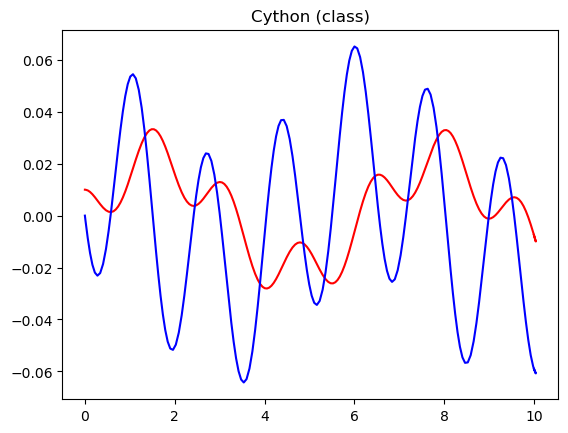

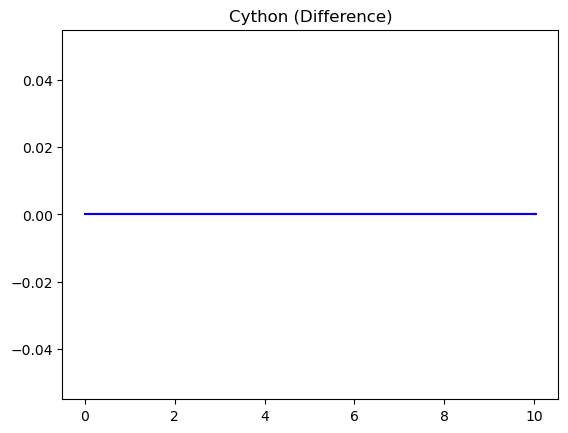

In [26]:
fig_cy_cl, ax_cy_cl = plt.subplots()
ax_cy_cl.plot(t_cy_cl, y_cy_cl[0], 'r')
ax_cy_cl.plot(t_cy_cl, y_cy_cl[1], 'b')
ax_cy_cl.set(title='Cython (class)')
plt.show()

fig_cy_cl_diff, ax_cy_cl_diff = plt.subplots()
if t_cy_cl.size != t_cy.size:
    print('SIZE MISMATCH')
    new_y1 = np.interp(t_cy, t_cy_cl, y_cy_cl[0])
    new_y2 = np.interp(t_cy, t_cy_cl, y_cy_cl[1])
else:
    new_y1 = y_cy_cl[0]
    new_y2 = y_cy_cl[1]
ax_cy_cl_diff.plot(t_cy, new_y1 - y_cy[0], 'r')
ax_cy_cl_diff.plot(t_cy, new_y2 - y_cy[1], 'b')
ax_cy_cl_diff.set(title='Cython (Difference)')
plt.show()

### Line Profiler

In [10]:
%load_ext line_profiler

In [27]:
%timeit PendulumSolver(pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

119 ms ± 8.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit nbrk_ode(pendulum_nb, pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

254 ms ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%timeit cyrk_ode(pendulum_cy, pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

1.16 s ± 65.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit cyrk_ode_2(pendulum_cy, pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

1.23 s ± 79.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%lprun -f cyrk_ode_2 cyrk_ode_2(pendulum_cy, pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

In [17]:
%lprun -f PendulumSolver.__init__ -f PendulumSolver.solve PendulumSolver(pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, auto_solve=True)

C:\ProgramData\Anaconda3\envs\cytest39\lib\site-packages\line_profiler\ipython_extension.py:71: UserWarning: Could not extract a code object for the object <slot wrapper '__init__' of '_cython_magic_53737a926b342d19e513bb0e0cb06b965bdbcd90.CySolver' objects>
  profile = LineProfiler(*funcs)


In [14]:
%prun -s cumulative PendulumSolver(pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, auto_solve=True)

In [27]:
import cProfile, pstats

In [28]:
cProfile.runctx("PendulumSolver(pendulum_time_span_10, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, auto_solve=True)", globals(), locals(), "Profile.prof")
s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Thu Aug 17 20:06:57 2023    Profile.prof

         1069361 function calls in 0.475 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.369    0.369    0.474    0.474 _cython_magic_b9f81bbb0c6aacc42d8ff47ce6ec11391e7d7910.pyx:510(_solve)
  1069340    0.105    0.000    0.105    0.000 _cython_magic_b9f81bbb0c6aacc42d8ff47ce6ec11391e7d7910.pyx:1237(diffeq)
        1    0.001    0.001    0.475    0.475 <string>:1(<module>)
        1    0.000    0.000    0.474    0.474 _cython_magic_b9f81bbb0c6aacc42d8ff47ce6ec11391e7d7910.pyx:89(__init__)
        1    0.000    0.000    0.475    0.475 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        3    0.000    0.000    0.000    0.000 {built-in method numpy.empty}
        3    0.000    0.000    0.000    0.000 numeric.py:150(ones)
        3    0.000    0.000    0.000    0.000 <

In [70]:
print('Performance')
print('Cython (class - solve only)')
# CyRK v0.6.0:
# 4.1ms, 4.03ms, 4.1ms
# 311us, 314us, 308us
# 300us, 298us, 300us
# 285us, 292us
# 295us
# 85.1us, 84.4us, 85us
# v0.6.2: 101us, 101us, 102us
# v0.7.0: 100us, 
#  ^^ 97.4us

Solver = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, auto_solve=False)
%timeit Solver.solve(reset=True)

print('Cython (class - build)')
# CyRK v0.6.0:
# 21.1us, 20.9us, 20.9us
# 21us, 20.7us, 20.9us
# 22us, 21.8us, 21.4us
# 22us, 22.9us
# 22.6us, 23.1us, 22.8us
# v0.6.2: 43.8us, 43.6us
# v0.7.0: 43.8us,

%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, auto_solve=False)

print('Cython (class - build and solve)')
# CyRK v0.6.0:
# 4.08ms, 4.21ms, 4.09ms
# 329us. 335us, 324us
# 319us, 310us, 318us
# 306us, 303us
# 103us, 102us, 102us
# v0.6.2: 128us, 127us
# v0.7.0: 126us

%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, auto_solve=True)

Performance
Cython (class - solve only)
74.9 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Cython (class - build)
45.4 µs ± 71.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Cython (class - build and solve)
131 µs ± 286 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
print('Expected Size Performance')

print('Default (1000)')
# 101us, 103us
# v0.6.2: 127us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

print('Way overshoot')
# 128us, 126us, 130us
# v0.6.2: 148us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100000)
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100000)

print('Nearly exactly whats needed')
# 108us, 109us
# v0.6.2: 124us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=200)
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=200)

print('undershoot once')
# 113us,
# v0.6.2: 129us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100)
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100)

print('undershoot 10x')
# 146us,
# v0.6.2: 164us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=19)
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=19)

print('undershoot max')
# 830us
# v0.6.2: 848us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=1)
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=1)


Expected Size Performance
Default (1000)
Growths 0
127 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Way overshoot
Growths 0
148 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Nearly exactly whats needed
Growths 0
124 µs ± 408 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
undershoot once
Growths 1
129 µs ± 476 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
undershoot 10x
Growths 9
164 µs ± 94.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
undershoot max
Growths 180
848 µs ± 2.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
